In [1]:
import matplotlib.pyplot as plt
import cv2
from chart import show, show_collection
import numpy as np

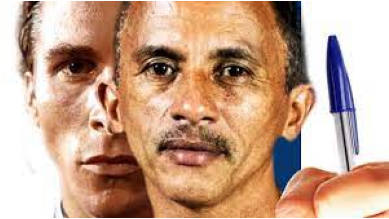

In [36]:
# Abertura da imagem usada durante o trabalho
img = cv2.imread("images/conceito.jpeg")

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show(img, scale=0.3)

---

### **Tons de Cinza**

Nesta função, estamos convertendo uma imagem RGB em escala de cinza utilizando transformação linear. Na primeira versão, cada pixel RGB é percorrido e multiplicado pelo valor correspondente para seu respectivo retorno na grayscale. Já na segunda versão, os canais RGB são acessados individualmente, e a intensidade de cinza de cada pixel é calculada através de uma combinação linear.

In [3]:
def rgb_to_gray(img):
    return (img@[0.2989, 0.5870, 0.1140]).astype(np.uint())

# Também pode ser escrito como
def rgb_to_gray(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.2989*r + 0.5870*g + 0.1140*b
    return gray

---

### **Isolamento dos canais RGB**

Para transformar a imagem em tons singulares de cada cor, estamos utilizando um loop que zera os respectivos canais indesejados, permanecendo apenas o requerido no momento, resultando em três cópias com apenas um canal de cor (vermelho, verde e azul, respectivamente).

<Figure size 720x504 with 0 Axes>

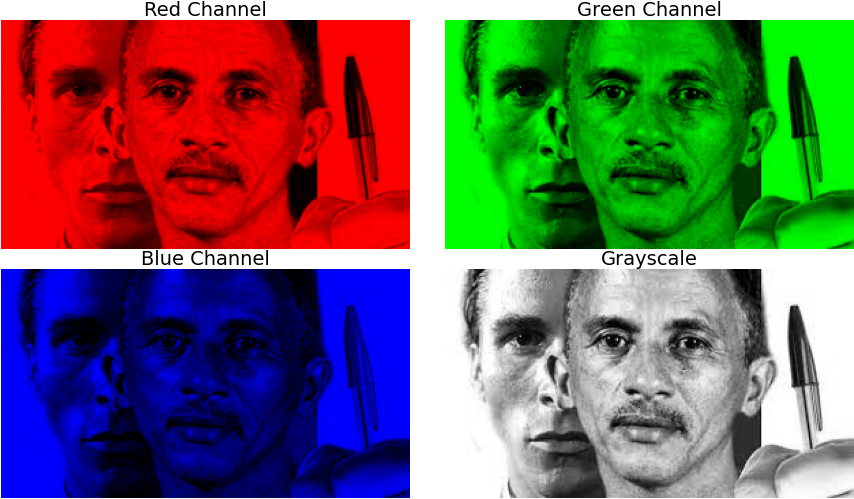

In [26]:
filtered_channels = []

for i in range(1,4):
    copia = img.copy()
    copia[:,:,i%3] = 0
    copia[:,:,(i+1)%3] = 0

    filtered_channels.append(copia)

filtered_channels.append(rgb_to_gray(img))
show_collection(filtered_channels, titles=["Red Channel", "Green Channel", "Blue Channel", "Grayscale"], fontsize=14, scale=0.15, cmap="gray", num_rows=2)

---

### **Efeito 3D**
Para que seja aplicado um efeito 3D à imagem, utilizaremos as 6 funções abaixo.

 As duas primeiras, "channel_first" e "channel_last", são funções de reorganização de canais, com a primeira colocando os canais no primeiro eixo da matriz tridimensional, e o segunda os colocando no último. 

In [5]:
def channel_first(img):
    return [[[img[j][k][i] for k in range(len(img[0]))]
             for j in range(len(img))] for i in range(len(img[0][0]))]

def channel_last(img):
    return [[[img[k][i][j] for k in range(len(img))]
             for j in range(len(img[0][0]))] for i in range(len(img[0]))]

As duas próximas funções, "rotate_left" e "rotate_right", realizam rotações de 90 graus na matriz tridimensional.

In [6]:
def rotate_left(img):
    return [[[img[j][-1-i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

def rotate_right(img):
    return [[[img[-1 - j][i][k] for k in range(len(img[0][0]))]
             for j in range(len(img))] for i in range(len(img[0]))]

A próxima função, "pad", realiza o preenchimento (padding) da imagem,  inserindo linhas e colunas inteiradas com um valor específico em todas as bordas da imagem. Após cada operação de preenchimento, a imagem é rotacionada 90 graus para a direita e, em seguida, para a esquerda. Isso resulta em um efeito de preenchimento simétrico e rotativo na imagem.

In [7]:
def pad(img, left_right_top_bottom, value=0):
    temp1 = img.copy()
    for i in range(left_right_top_bottom[2]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[3]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_right(temp1)
    for i in range(left_right_top_bottom[0]):
        temp1.insert(0, [[value for i in range(len(temp1[0][0]))]
                         for i in range(len(temp1[0]))])
    for i in range(left_right_top_bottom[1]):
        temp1.insert(-1, [[value for i in range(len(temp1[0][0]))]
                          for i in range(len(temp1[0]))])
    temp1 = rotate_left(temp1)
    return temp1

 Já a última função, "electronic_wave_effect", irá utilizar das funções anteriores para implementar o efeito 3D de fato. Primeiramente, os canais RGB são reorganizados para que eles estejam no primeiro eixo da matriz. Após isso, cada canal RGB, individualmente, será preenchido em diferentes direções com base nos valores fornecidos. 

In [8]:
def electronic_wave_effect(img, strength=5, bgvalue=0):
    temp = channel_first(img)
    R = pad(channel_last([temp[0]]), (0, 2 * strength, 2 * strength, 0),
            bgvalue)

    G = pad(channel_last([temp[1]]), (strength, strength, strength, strength),
            bgvalue)

    B = pad(channel_last([temp[2]]), (2 * strength, 0, 0, 2 * strength),
            bgvalue)

    return channel_last(channel_first(R) + channel_first(G) + channel_first(B))

Em resumo, a função cria uma sobreposição de canais RGB que são deslocados e sobrepostos entre si, criando um efeito visual tridimensional.

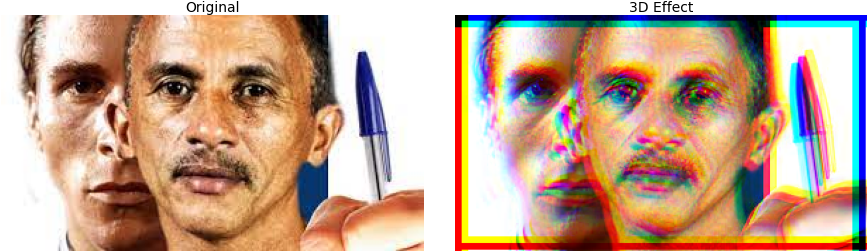

In [35]:
show_collection([img, np.array(electronic_wave_effect(img))], scale=0.15, titles=["Original", "3D Effect"])

---

### **Blur**

Nesta aplicação, usaremos o efeito de blur no contexto de imagens. Como o nome já sugere, a sua principal função é a de "borrar" uma imagem, mas há também outros algoritmos que permitem o seu uso para a suavização de fotos tal como pode ser visto abaixo.

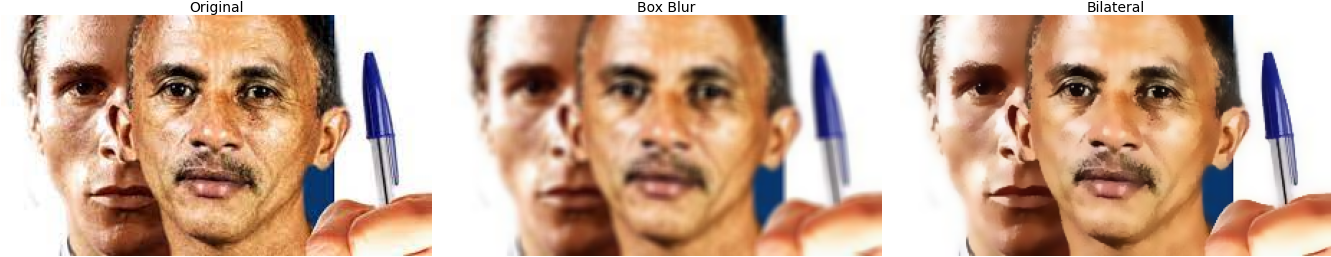

In [28]:
show_collection([img, cv2.blur(img, (5, 5)), cv2.bilateralFilter(img, 9, 75, 75)], titles=["Original", "Box Blur", "Bilateral"], scale=0.15)

Assim, cada uma dessas imagens foi criada utilizando diferentes algoritmos de blur, resultando nesses resultados distintos nas imagens geradas. Além disso, é claro que o seu uso por programadores tende a ser através de bibliotecas de terceiros como o próprio OpenCV, mas a seguir será apresentado em código um dos algoritmos usados previamente, também chamado de Box Blur.

In [11]:
def box_blur(img):
    img = img.copy()
    blurred = []
    for i in range(2, img.shape[0]-2):
        row = []
        for j in range(2, img.shape[1]-2):
            row.append(kernel_avg(i, j, img))
        blurred.append(row)
    return np.array(blurred)

def kernel_avg(center_x, center_y, img):
    result = 0
    for i in range(-2, 3):
        for j in range(-2, 3):
            result += img[center_x+i,center_y+j]//25
    return result

Ao contrário do que pode parecer a primeira vista, o algoritmo do Box Blur é bem simples, ele consiste em selecionar cada pixel "P" que não esteja na borda da matriz que representa a imagem original, e criar uma nova imagem a partir da média de todos os pixels que são adjacentes a "P", incluindo ele mesmo.

Assim, vamos iniciar com a seguinte matriz, note que para fins de simplificação, não foi considerada a separação entre RGB, tendo a imagem apenas um canal de cor.

$$
image = \begin{bmatrix}
7 & 4 & 0 & 1\\
5 & 6 & 2 & 2\\
6 & 10 & 7 & 8\\
1 & 4 & 2 & 0
\end{bmatrix}
\rightarrow
\begin{bmatrix}
a & b \\
d & e
\end{bmatrix}
$$

$$
\begin{aligned}
\text{Passo 1:} & \quad
\begin{bmatrix}
\color{red}{7} & \color{red}{4} & \color{red}{0} & 1\\
\color{red}{5} & \color{blue}{6} & \color{red}{2} & 2\\
\color{red}{6} & \color{red}{10} & \color{red}{7} & 8\\
1 & 4 & 2 & 0
\end{bmatrix}
\rightarrow
\begin{bmatrix}
\color{blue}{5} & b \\
d & e
\end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
\text{Passo 2:} & \quad
\begin{bmatrix}
7 & \color{red}{4} & \color{red}{0} & \color{red}{1}\\
5 & \color{red}{6} & \color{blue}{2} & \color{red}{2}\\
6 & \color{red}{10} & \color{red}{7} & \color{red}{8}\\
1 & 4 & 2 & 0
\end{bmatrix}
\rightarrow
\begin{bmatrix}
5 & \color{blue}{4} \\
d & e
\end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
\text{Passo 3:} & \quad
\begin{bmatrix}
7 & 4 & 0 & 1\\
\color{red}{5} & \color{red}{6} & \color{red}{2} & 2\\
\color{red}{6} & \color{blue}{10} & \color{red}{7} & 8\\
\color{red}{1} & \color{red}{4} & \color{red}{2} & 0
\end{bmatrix}
\rightarrow
\begin{bmatrix}
5 & 4 \\
\color{blue}{4} & e
\end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
\text{Passo 4:} & \quad
\begin{bmatrix}
7 & 4 & 0 & 1\\
5 & \color{red}{6} & \color{red}{2} & \color{red}{2}\\
6 & \color{red}{10} & \color{blue}{7} & \color{red}{8}\\
1 & \color{red}{4} & \color{red}{2} & \color{red}{0}
\end{bmatrix}
\rightarrow
\begin{bmatrix}
5 & 4 \\
4 & \color{blue}{4}
\end{bmatrix}
\end{aligned}
$$

$$
image = \begin{bmatrix}
7 & 4 & 0 & 1\\
5 & 6 & 2 & 2\\
6 & 10 & 7 & 8\\
1 & 4 & 2 & 0
\end{bmatrix}
\rightarrow
\begin{bmatrix}
5 & 4 \\
4 & 4
\end{bmatrix}
$$

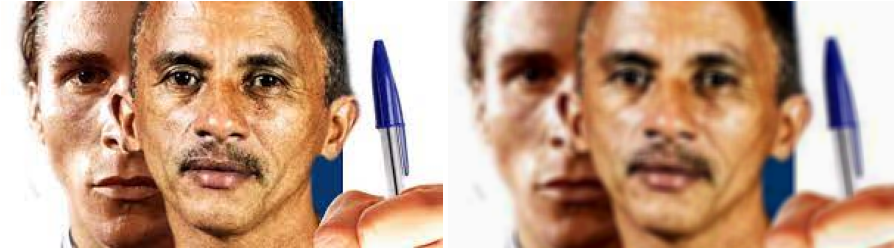

In [29]:
blurred_image = box_blur(img)
show_collection([img, blurred_image], scale=0.15)

---

### Extração de escala de cores 

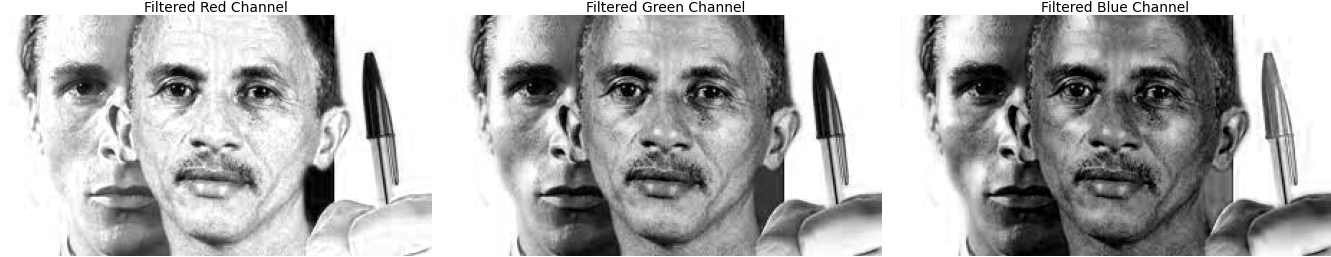

In [30]:
def extract_image_channels(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    return r, g, b

show_collection(extract_image_channels(img), titles=["Filtered Red Channel", "Filtered Green Channel", "Filtered Blue Channel"], scale=0.15, cmap="gray")

---

### **RGB para XYZ**

A escala XYZ é uma escala tricromática sendo 

* ***X***: Representa a resposta de luminância (brilho) da retina aos comprimentos de onda de luz no intervalo de azul-verde.
* ***Y***: Representa a luminância (brilho) e é uma medida da quantidade total de luz percebida.
* ***Z***: Representa a resposta de luminância (brilho) da retina aos comprimentos de onda de luz no intervalo de amarelo.

In [14]:
def gamma_correction(value):
    return np.where(value <= 0.04045, value / 12.92, ((value + 0.055) / 1.055) ** 2.4)


def rgb_to_xyz(rgb):
    rgb = rgb / 255.0
    
    xyz = np.dot(rgb, np.array([[0.4124, 0.3576, 0.1805],
                                [0.2126, 0.7152, 0.0722],
                                [0.0193, 0.1192, 0.9505]]).T).clip(0, 1)

    return xyz

Ao multiplicar uma matriz por um vetor, estamos realizando uma combinação linear dos elementos do vetor. No caso da função **rgb_to_xyz**, estamos multiplicando a matriz de transformação por um vetor de valores RGB.

A função **gamma_correction** aplica uma correção não linear aos valores RGB. Essa correção é necessária porque o olho humano não responde linearmente à luz. Valores mais escuros são expandidos para mostrar mais detalhes, enquanto valores mais claros são comprimidos para evitar estouro.

Em resumo, a função **rgb_to_xyz** simplesmente multiplica a matriz de transformação pelos valores RGB normalizados.

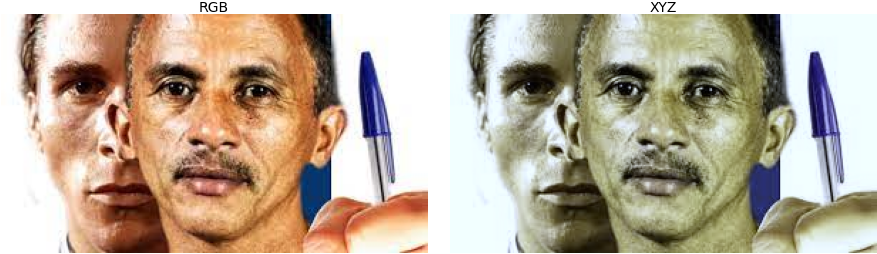

In [15]:
xyz_img = rgb_to_xyz(img)

show_collection([img, xyz_img], titles=["RGB", "XYZ"], scale=0.15)